In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
%pip install lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.pipeline import Pipeline

# Set plot style
sns.set_theme(style="whitegrid")

In [3]:
# ==========================================
# 1. LOAD DATA & SPLIT
# ==========================================
print("Loading the Top-200 features dataset...")
df = pd.read_csv('vodafone_age_top200_sprint2.csv')

X = df.drop(columns=['target'])
y = df['target']

# Train / Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Loading the Top-200 features dataset...
Training set shape: (50400, 200)
Test set shape: (12600, 200)


In [4]:
# ==========================================
# 2 & 3. PIPELINES & BASELINE EVALUATION
# ==========================================
pipelines = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1))
    ]),
    "Random Forest": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    "LightGBM": Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LGBMClassifier(random_state=42, n_jobs=-1))
    ])
}

results = []
best_model_name = "LightGBM" # Assuming LightGBM will be best based on EDA
best_y_pred = None

print("\nTraining models through pipelines...\n")
for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    
    # Fit the pipeline
    pipeline.fit(X_train, y_train)
    
    # Predict
    y_pred = pipeline.predict(X_test)
    
    # Save predictions of LightGBM for the detailed report later
    if name == best_model_name:
        best_y_pred = y_pred
    
    # Calculate Metrics (using weighted average for imbalanced multiclass)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (Weighted)": prec,
        "Recall (Weighted)": rec,
        "F1 Score (Weighted)": f1
    })


Training models through pipelines...

Training Logistic Regression...
Training Random Forest...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 28526
[LightGBM] [Info] Number of data points in the train set: 50400, number of used features: 200
[LightGBM] [Info] Start training from score -3.671570
[LightGBM] [Info] Start training from score -2.956054
[LightGBM] [Info] Start training from score -1.655939
[LightGBM] [Info] Start training from score -1.240752
[LightGBM] [Info] Start training from score -1.246532
[LightGBM] [Info] Start training from score -1.864586


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [5]:
# Create a comparison table
results_df = pd.DataFrame(results).sort_values(by="F1 Score (Weighted)", ascending=False)
print("\n=== MODEL COMPARISON TABLE ===")
print(results_df.to_string(index=False))

# Print detailed Classification Report for the best model
print(f"\n=== DETAILED CLASSIFICATION REPORT: {best_model_name} ===")
print(classification_report(y_test, best_y_pred, zero_division=0))


=== MODEL COMPARISON TABLE ===
              Model  Accuracy  Precision (Weighted)  Recall (Weighted)  F1 Score (Weighted)
           LightGBM  0.464286              0.468113           0.464286             0.463485
      Random Forest  0.447460              0.458745           0.447460             0.444842
Logistic Regression  0.416508              0.419438           0.416508             0.412395

=== DETAILED CLASSIFICATION REPORT: LightGBM ===
              precision    recall  f1-score   support

           1       0.53      0.31      0.39       320
           2       0.49      0.43      0.46       656
           3       0.44      0.42      0.43      2406
           4       0.44      0.42      0.43      3643
           5       0.45      0.54      0.49      3622
           6       0.57      0.49      0.53      1953

    accuracy                           0.46     12600
   macro avg       0.49      0.44      0.46     12600
weighted avg       0.47      0.46      0.46     12600



Generating Model Comparison Chart...


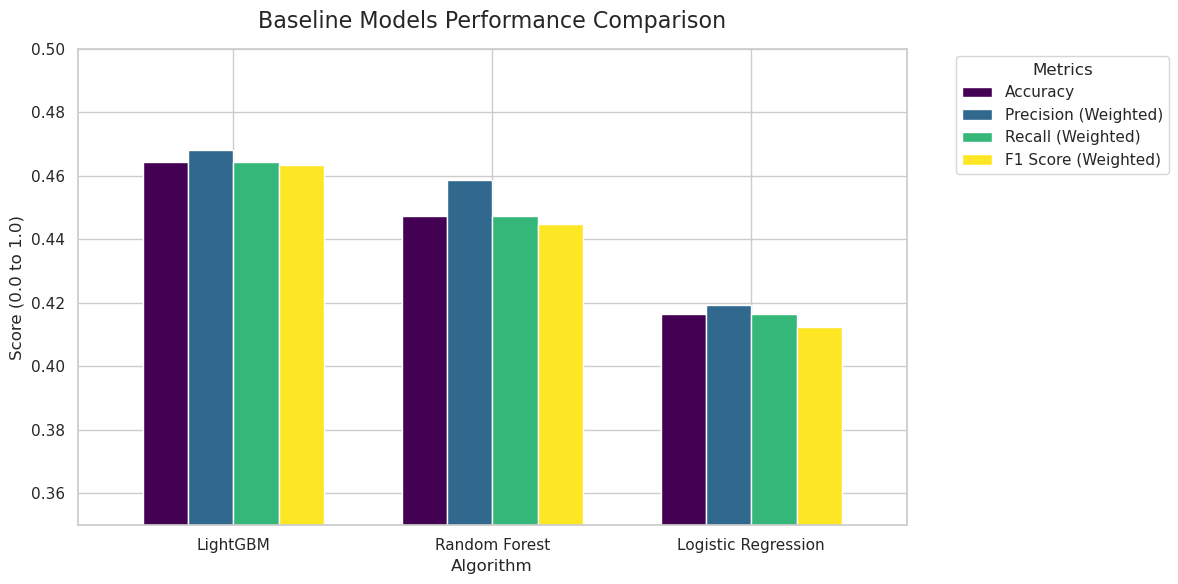

In [6]:
# ==========================================
# 1. VISUALIZE MODEL COMPARISON (BAR CHART)
# ==========================================
print("Generating Model Comparison Chart...")

# Set 'Model' column as index for easy plotting
plot_df = results_df.set_index("Model")

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
plot_df.plot(kind='bar', ax=ax, colormap='viridis', width=0.7)

plt.title('Baseline Models Performance Comparison', fontsize=16, pad=15)
plt.xlabel('Algorithm', fontsize=12)
plt.ylabel('Score (0.0 to 1.0)', fontsize=12)
plt.xticks(rotation=0, fontsize=11)
plt.ylim(0.35, 0.50) # Zoom in to highlight the differences

# Move legend outside the plot
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()